# Подключение библиотек

In [1]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

print(device)

cpu


#### Разделение набора данных на выборки

In [3]:
train_path=os.path.abspath('train_list')
test_path=os.path.abspath('test_list')
val_path=os.path.abspath('val_list')


df = pd.read_csv('annotation.csv', sep = ',', header=None)

df = df.drop(df.index[0])
df.drop(0, axis=1, inplace=True)
df.rename(columns={1: 'full_path', 2: 'img_class'}, inplace=True)
df.reset_index(inplace=True)
print(df)


if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:  
    '''
    Загружает  изображение из датафрейма по заданному пути 
    Parameters
        df(pd.core.frame.DataFrame): 
         датафрейм изображений 
        path(str): 
         путь до изображения
        i(int): 
         номер изображения 
    '''  
   
    
    image_path = os.path.abspath(os.path.join(*df.full_path[i].split("\\")))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.img_class[i]}.{i}.jpg'), image)

def load_val(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    ''' 
    Загружает  изображение из датафрейма по заданному пути 
    Parameters
        df(pd.core.frame.DataFrame): 
         датафрейм изображений 
        path(str): 
         путь до изображения
        i(int): 
         номер изображения 
    '''  
 
    image_path = os.path.join(*df.full_path[i].split("\\"))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(*path.split("/"), f'{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    '''
    Загружает  изображение из датафрейма по заданному пути 
    Parameters
        df(pd.core.frame.DataFrame): 
         датафрейм изображений 
        path(str): 
         путь до изображения
        i(int): 
         номер изображения 
    '''
 
    image_path = os.path.join(*df.full_path[i].split("\\"))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)


for i in range(800):
    load_train(df, train_path, i)
for i in range(800,900):
    load_test(df,test_path,i)
for i in range(1800,1900):
    load_test(df,test_path,i)
for i in range(900,1000):
    load_val(df,val_path,i)
for i in range(1900,1999):
    load_val(df,val_path,i)

train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))

train_list, val_list = train_test_split(train_list, test_size=0.1)

      index             full_path img_class
0         1  dataset\cat\0000.jpg       cat
1         2  dataset\cat\0001.jpg       cat
2         3  dataset\cat\0002.jpg       cat
3         4  dataset\cat\0003.jpg       cat
4         5  dataset\cat\0004.jpg       cat
...     ...                   ...       ...
1995   1996  dataset\dog\0995.jpg       dog
1996   1997  dataset\dog\0996.jpg       dog
1997   1998  dataset\dog\0997.jpg       dog
1998   1999  dataset\dog\0998.jpg       dog
1999   2000  dataset\dog\0999.jpg       dog

[2000 rows x 3 columns]


#### Проверка картинок

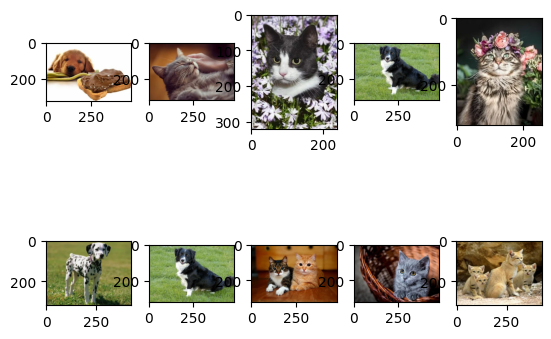

In [4]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

##### Увеличение изображений

In [6]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

#### Загрузка наборов

In [7]:
from PIL import Image
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [8]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

#### Проверка данных

In [9]:
print(train_data[1])
print(val_data[0][1])

(tensor([[[0.3961, 0.3961, 0.3882,  ..., 0.4902, 0.4902, 0.4902],
         [0.3961, 0.3961, 0.3882,  ..., 0.4902, 0.4902, 0.4902],
         [0.3961, 0.3961, 0.3882,  ..., 0.4902, 0.4902, 0.4902],
         ...,
         [0.9804, 0.9804, 0.9843,  ..., 0.7765, 0.7686, 0.7686],
         [0.9804, 0.9804, 0.9843,  ..., 0.7804, 0.7725, 0.7725],
         [0.9804, 0.9804, 0.9843,  ..., 0.7804, 0.7725, 0.7725]],

        [[0.3176, 0.3176, 0.3098,  ..., 0.4196, 0.4196, 0.4196],
         [0.3176, 0.3176, 0.3098,  ..., 0.4196, 0.4196, 0.4196],
         [0.3176, 0.3176, 0.3098,  ..., 0.4196, 0.4196, 0.4196],
         ...,
         [0.7882, 0.7882, 0.7882,  ..., 0.5412, 0.5333, 0.5333],
         [0.7882, 0.7882, 0.7882,  ..., 0.5451, 0.5373, 0.5373],
         [0.7882, 0.7882, 0.7882,  ..., 0.5451, 0.5373, 0.5373]],

        [[0.2824, 0.2824, 0.2745,  ..., 0.3765, 0.3765, 0.3765],
         [0.2824, 0.2824, 0.2745,  ..., 0.3765, 0.3765, 0.3765],
         [0.2824, 0.2824, 0.2745,  ..., 0.3765, 0.3765, 0

# Обучение

In [10]:
lr = 0.001 
batch_size = 10 
epochs = 10 

In [11]:
def create_loaders():
    train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)
    return (train_loader, test_loader, val_loader)

train_loader, test_loader, val_loader = create_loaders()

In [12]:
print(len(train_data), len(train_loader))

1620 162


In [13]:
print(len(val_data), len(val_loader))

180 18


#### Построение модели

#### модель сверточной нейросети для решения задачи классификации

In [14]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )


        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [15]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [16]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
train_data[0][0].shape

1620 162
180 18


torch.Size([3, 224, 224])

#### Цикл обучения

Epoch : 1, train accuracy : 0.6234566569328308, train loss : 0.6500699520111084
Epoch : 1, val_accuracy : 0.5777778029441833, val_loss : 0.6924514770507812
Epoch : 2, train accuracy : 0.6858024001121521, train loss : 0.6060544848442078
Epoch : 2, val_accuracy : 0.694444477558136, val_loss : 0.6027206778526306
Epoch : 3, train accuracy : 0.6993827223777771, train loss : 0.5774700045585632
Epoch : 3, val_accuracy : 0.7277777791023254, val_loss : 0.5452263951301575
Epoch : 4, train accuracy : 0.7148149609565735, train loss : 0.554789125919342
Epoch : 4, val_accuracy : 0.7444444298744202, val_loss : 0.5420697331428528
Epoch : 5, train accuracy : 0.7129623889923096, train loss : 0.5548314452171326
Epoch : 5, val_accuracy : 0.7555555105209351, val_loss : 0.528232753276825
Epoch : 6, train accuracy : 0.742592453956604, train loss : 0.5185572504997253
Epoch : 6, val_accuracy : 0.6722222566604614, val_loss : 0.5857819318771362
Epoch : 7, train accuracy : 0.7314811944961548, train loss : 0.52562

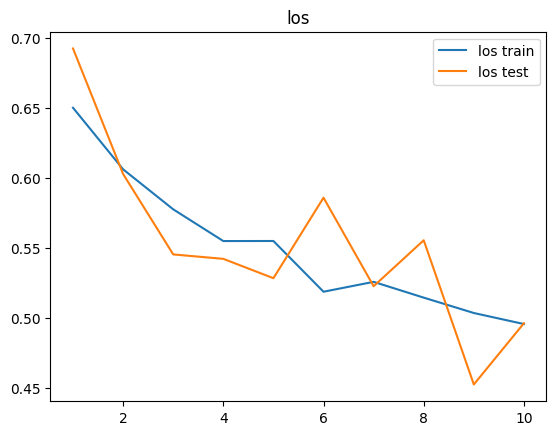

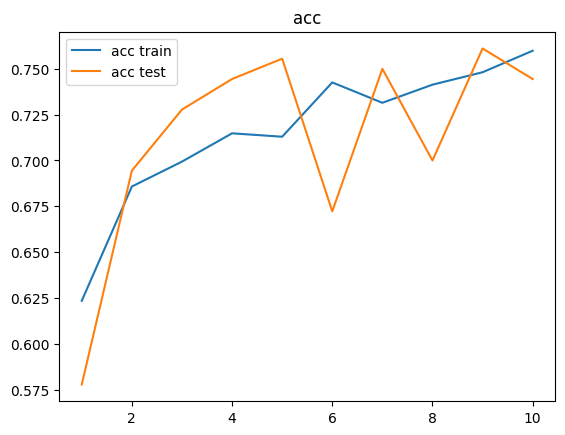

In [17]:


train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

def train(model, epochs):

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()


  epoch_val_accuracy_list = []
  epoch_val_loss_list = []
  epoch_accuracy_list = []
  epoch_loss_list = []


  for epoch in range(epochs):
      epoch_loss = 0
      epoch_accuracy = 0

      for data, label in train_loader:
          data = data.to(device)
          label = label.to(device)

          output = model(data)
          loss = criterion(output, label)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          acc = ((output.argmax(dim=1) == label).float().mean())
          epoch_accuracy += acc/len(train_loader)
          epoch_loss += loss/len(train_loader)

      print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
      epoch_accuracy_list.append(epoch_accuracy)
      epoch_loss_list.append(epoch_loss)
      with torch.no_grad():
          epoch_val_accuracy=0
          epoch_val_loss =0
          for data, label in val_loader:
              data = data.to(device)
              label = label.to(device)
              val_output = model(data)
              val_loss = criterion(val_output,label)


              acc = ((val_output.argmax(dim=1) == label).float().mean())
              epoch_val_accuracy += acc/ len(val_loader)
              epoch_val_loss += val_loss/ len(val_loader)

          print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

      epoch_val_accuracy_list.append(epoch_val_accuracy)
      epoch_val_loss_list.append(epoch_val_loss)

  return(epoch_val_accuracy_list,epoch_val_loss_list,
  epoch_accuracy_list,
  epoch_loss_list)

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

def show_plot(lis, list_val, text):
  x = list(range(1, len(lis)+ 1))
  plt.plot(x, lis, label = text+" train")
  plt.plot(x, list_val, label = text+" test")
  plt.title(text)
  plt.legend()
  plt.show()

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.8141974806785583, train loss : 0.37758705019950867
Epoch : 1, val_accuracy : 0.8166666626930237, val_loss : 0.39982256293296814
Epoch : 2, train accuracy : 0.832716166973114, train loss : 0.3732559382915497
Epoch : 2, val_accuracy : 0.8333333730697632, val_loss : 0.3936198651790619
Epoch : 3, train accuracy : 0.8129627108573914, train loss : 0.4009215831756592
Epoch : 3, val_accuracy : 0.8055555820465088, val_loss : 0.4182225465774536
Epoch : 4, train accuracy : 0.8191354870796204, train loss : 0.3812965750694275
Epoch : 4, val_accuracy : 0.7444444298744202, val_loss : 0.4803234040737152
Epoch : 5, train accuracy : 0.8098764419555664, train loss : 0.39916518330574036
Epoch : 5, val_accuracy : 0.800000011920929, val_loss : 0.4693022072315216
Epoch : 6, train accuracy : 0.8314813375473022, train loss : 0.3746667206287384
Epoch : 6, val_accuracy : 0.8277778029441833, val_loss : 0.4241667687892914
Epoch : 7, train accuracy : 0.8123455047607422, train loss : 0.

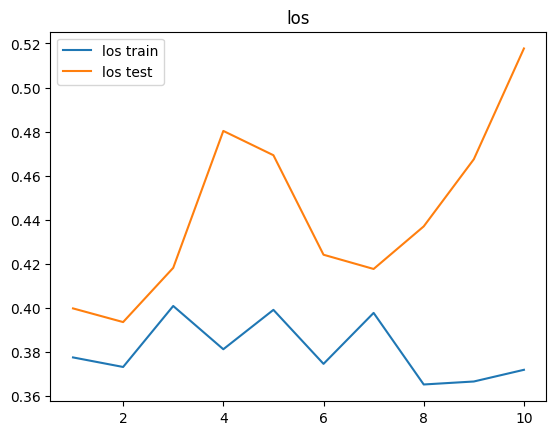

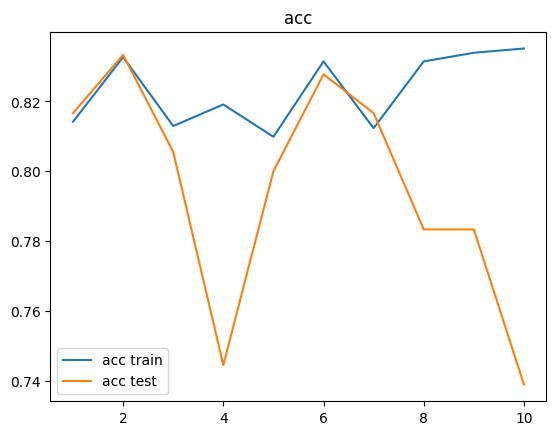

In [21]:
lr = 0.0005 # learning_rate
batch_size = 10 # we will use mini-batch method

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.6012347340583801, train loss : 0.664667010307312
Epoch : 1, val_accuracy : 0.5833333134651184, val_loss : 0.657403826713562
Epoch : 2, train accuracy : 0.6629628539085388, train loss : 0.6139304041862488
Epoch : 2, val_accuracy : 0.6666666269302368, val_loss : 0.6290148496627808
Epoch : 3, train accuracy : 0.6598765254020691, train loss : 0.6035448908805847
Epoch : 3, val_accuracy : 0.6555556058883667, val_loss : 0.6541986465454102
Epoch : 4, train accuracy : 0.6950618028640747, train loss : 0.5677528977394104
Epoch : 4, val_accuracy : 0.7055554986000061, val_loss : 0.6569255590438843
Epoch : 5, train accuracy : 0.7216048836708069, train loss : 0.5565253496170044
Epoch : 5, val_accuracy : 0.6833333373069763, val_loss : 0.6104918718338013
Epoch : 6, train accuracy : 0.7271602153778076, train loss : 0.5326325297355652
Epoch : 6, val_accuracy : 0.7000000476837158, val_loss : 0.5660921335220337
Epoch : 7, train accuracy : 0.7277776002883911, train loss : 0.541

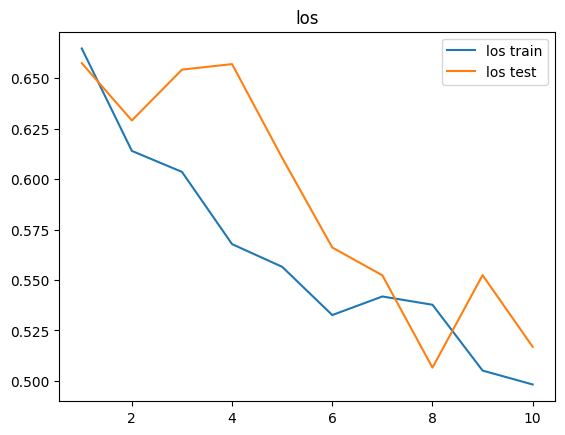

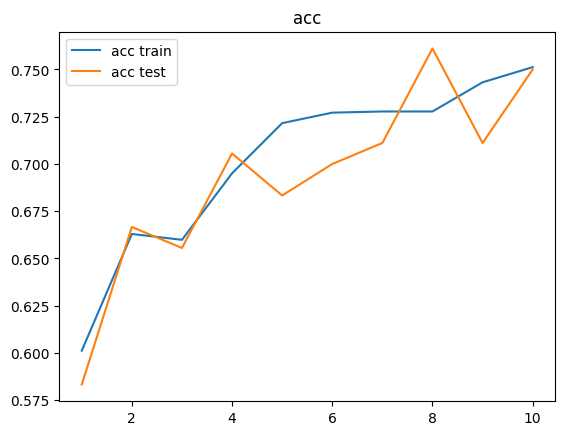

In [22]:
lr = 0.0007 # learning_rate
batch_size = 10 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.6117284893989563, train loss : 0.6493284106254578
Epoch : 1, val_accuracy : 0.5722222328186035, val_loss : 0.6864138841629028
Epoch : 2, train accuracy : 0.6660494804382324, train loss : 0.6104883551597595
Epoch : 2, val_accuracy : 0.6777777671813965, val_loss : 0.6167675256729126
Epoch : 3, train accuracy : 0.6537036299705505, train loss : 0.610493004322052
Epoch : 3, val_accuracy : 0.6611111164093018, val_loss : 0.6343858242034912
Epoch : 4, train accuracy : 0.7030863761901855, train loss : 0.5740804672241211
Epoch : 4, val_accuracy : 0.6611111164093018, val_loss : 0.6073576211929321
Epoch : 5, train accuracy : 0.7074073553085327, train loss : 0.5702475905418396
Epoch : 5, val_accuracy : 0.7111110687255859, val_loss : 0.5547999143600464
Epoch : 6, train accuracy : 0.7086419463157654, train loss : 0.5500193238258362
Epoch : 6, val_accuracy : 0.7388888597488403, val_loss : 0.5483728051185608
Epoch : 7, train accuracy : 0.73333340883255, train loss : 0.5241

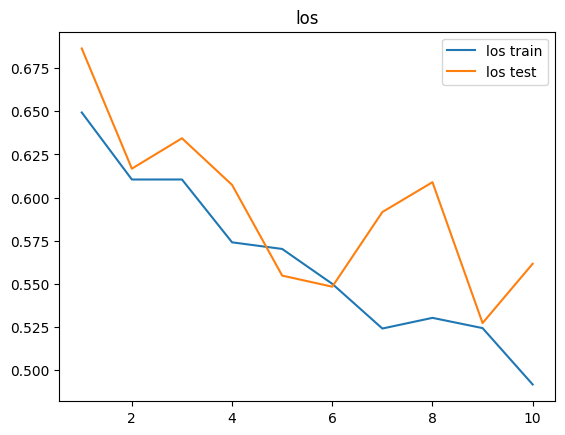

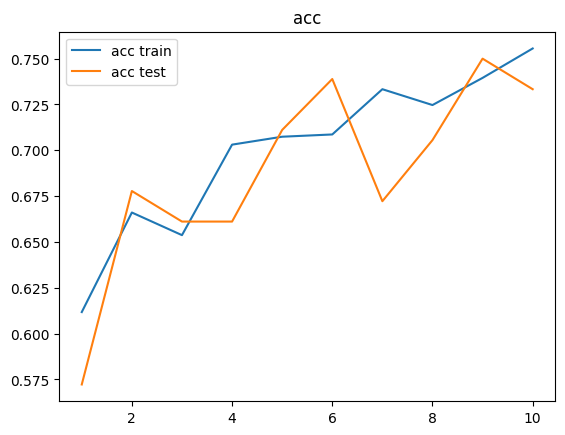

In [23]:
lr = 0.001 # learning_rate
batch_size = 20 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.6203703284263611, train loss : 0.6436971426010132
Epoch : 1, val_accuracy : 0.6111111044883728, val_loss : 0.6856484413146973
Epoch : 2, train accuracy : 0.6833332777023315, train loss : 0.5940648913383484
Epoch : 2, val_accuracy : 0.6555556058883667, val_loss : 0.6163033246994019
Epoch : 3, train accuracy : 0.7160494923591614, train loss : 0.5665559768676758
Epoch : 3, val_accuracy : 0.699999988079071, val_loss : 0.5968131422996521
Epoch : 4, train accuracy : 0.7265430688858032, train loss : 0.5541697144508362
Epoch : 4, val_accuracy : 0.7444444298744202, val_loss : 0.5247796177864075
Epoch : 5, train accuracy : 0.722222089767456, train loss : 0.5370763540267944
Epoch : 5, val_accuracy : 0.6666666269302368, val_loss : 0.5929297208786011
Epoch : 6, train accuracy : 0.7314814925193787, train loss : 0.5350109338760376
Epoch : 6, val_accuracy : 0.7722222805023193, val_loss : 0.5108866691589355
Epoch : 7, train accuracy : 0.7629629373550415, train loss : 0.505

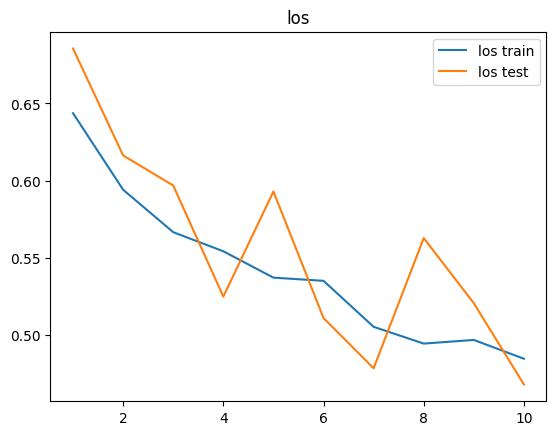

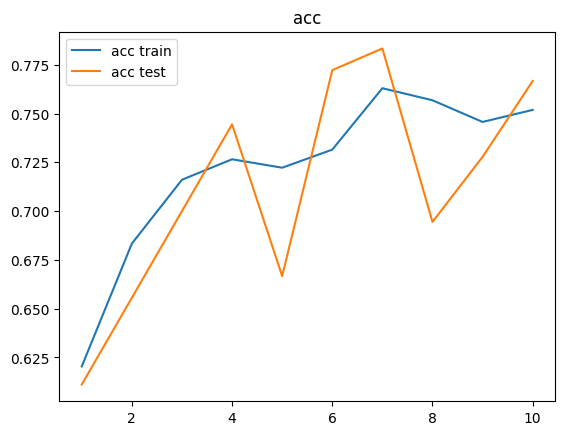

In [24]:
lr = 0.0005 # learning_rate
batch_size = 20 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.5975309610366821, train loss : 0.6615790128707886
Epoch : 1, val_accuracy : 0.6111111044883728, val_loss : 0.6477217674255371
Epoch : 2, train accuracy : 0.6858025193214417, train loss : 0.593245804309845
Epoch : 2, val_accuracy : 0.6555555462837219, val_loss : 0.5941029787063599
Epoch : 3, train accuracy : 0.7160495519638062, train loss : 0.5631836652755737
Epoch : 3, val_accuracy : 0.6833332777023315, val_loss : 0.5973694920539856
Epoch : 4, train accuracy : 0.6870369911193848, train loss : 0.5829405188560486
Epoch : 4, val_accuracy : 0.6555555462837219, val_loss : 0.6264116168022156
Epoch : 5, train accuracy : 0.699999988079071, train loss : 0.5669519305229187
Epoch : 5, val_accuracy : 0.7055554986000061, val_loss : 0.5372805595397949
Epoch : 6, train accuracy : 0.725308895111084, train loss : 0.5268773436546326
Epoch : 6, val_accuracy : 0.6666666269302368, val_loss : 0.5329095721244812
Epoch : 7, train accuracy : 0.7302469611167908, train loss : 0.5142

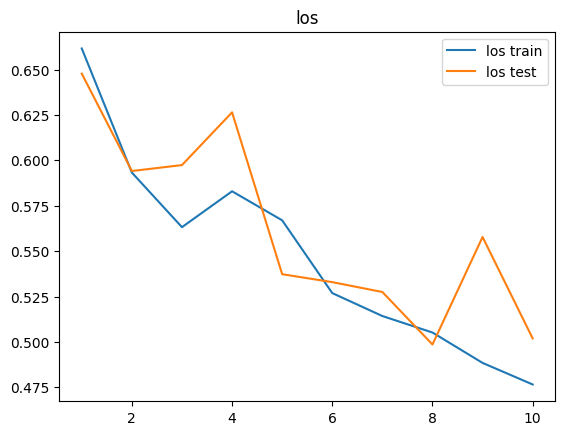

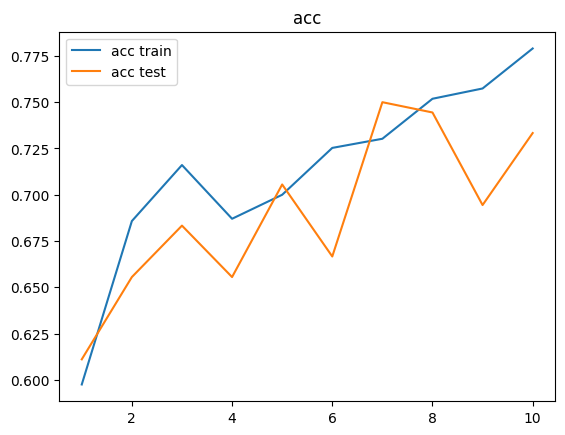

In [25]:
lr = 0.0007 # learning_rate
batch_size = 20 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.596969723701477, train loss : 0.6593226194381714
Epoch : 1, val_accuracy : 0.6549999713897705, val_loss : 0.6341915130615234
Epoch : 2, train accuracy : 0.6624242067337036, train loss : 0.6119880676269531
Epoch : 2, val_accuracy : 0.6166666746139526, val_loss : 0.6738533973693848
Epoch : 3, train accuracy : 0.7003029584884644, train loss : 0.5866388082504272
Epoch : 3, val_accuracy : 0.7366666793823242, val_loss : 0.5674988627433777
Epoch : 4, train accuracy : 0.7045453786849976, train loss : 0.5710629224777222
Epoch : 4, val_accuracy : 0.7100000381469727, val_loss : 0.5805714130401611
Epoch : 5, train accuracy : 0.7257574796676636, train loss : 0.5559834241867065
Epoch : 5, val_accuracy : 0.6916667222976685, val_loss : 0.6287643909454346
Epoch : 6, train accuracy : 0.741212010383606, train loss : 0.5434013605117798
Epoch : 6, val_accuracy : 0.7049999833106995, val_loss : 0.5341001749038696
Epoch : 7, train accuracy : 0.7418180704116821, train loss : 0.510

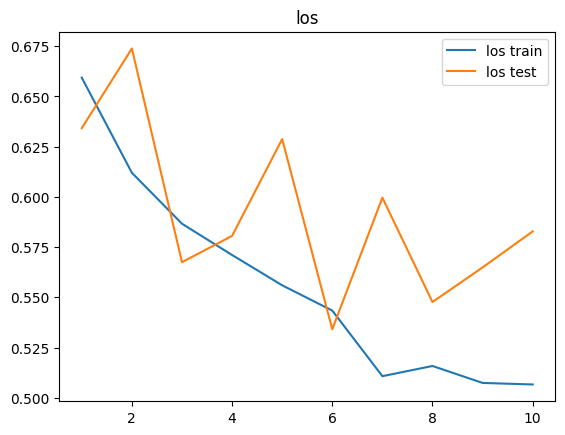

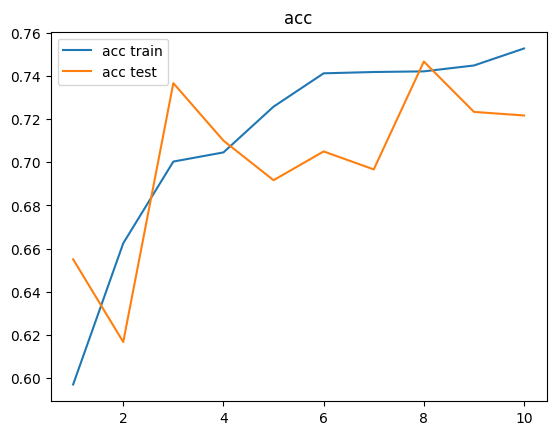

In [26]:
lr = 0.001 # learning_rate
batch_size = 50 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.6227272748947144, train loss : 0.653070330619812
Epoch : 1, val_accuracy : 0.6033333539962769, val_loss : 0.6959131956100464
Epoch : 2, train accuracy : 0.6599999666213989, train loss : 0.6237209439277649
Epoch : 2, val_accuracy : 0.6316666603088379, val_loss : 0.639225959777832
Epoch : 3, train accuracy : 0.6639394164085388, train loss : 0.6079211831092834
Epoch : 3, val_accuracy : 0.6733333468437195, val_loss : 0.6206587553024292
Epoch : 4, train accuracy : 0.6730302572250366, train loss : 0.5983820557594299
Epoch : 4, val_accuracy : 0.6700000166893005, val_loss : 0.6393667459487915
Epoch : 5, train accuracy : 0.7090908288955688, train loss : 0.5675681829452515
Epoch : 5, val_accuracy : 0.7016666531562805, val_loss : 0.5907813906669617
Epoch : 6, train accuracy : 0.710303008556366, train loss : 0.5645209550857544
Epoch : 6, val_accuracy : 0.7266666889190674, val_loss : 0.56353360414505
Epoch : 7, train accuracy : 0.7321210503578186, train loss : 0.538160

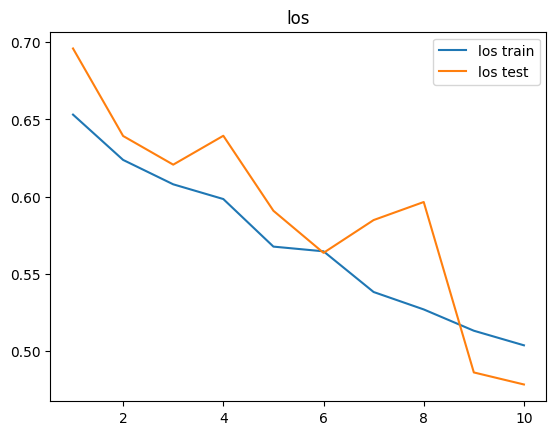

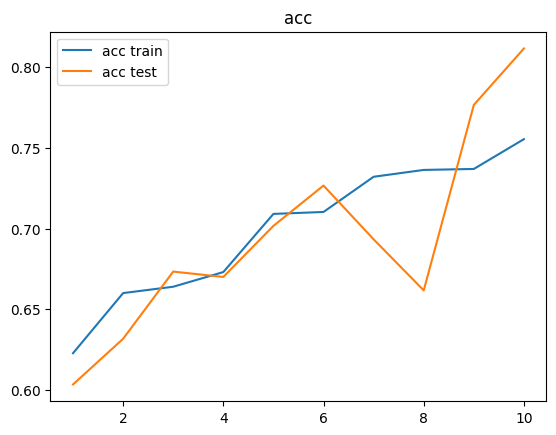

In [27]:
lr = 0.0005 # learning_rate
batch_size = 50 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

Epoch : 1, train accuracy : 0.5884848237037659, train loss : 0.6639510989189148
Epoch : 1, val_accuracy : 0.6016666889190674, val_loss : 0.657441258430481
Epoch : 2, train accuracy : 0.6548484563827515, train loss : 0.6223667860031128
Epoch : 2, val_accuracy : 0.628333330154419, val_loss : 0.6922303438186646
Epoch : 3, train accuracy : 0.6703029870986938, train loss : 0.6065946221351624
Epoch : 3, val_accuracy : 0.6583333015441895, val_loss : 0.5956757068634033
Epoch : 4, train accuracy : 0.6857575178146362, train loss : 0.5808382034301758
Epoch : 4, val_accuracy : 0.6850000023841858, val_loss : 0.5840044021606445
Epoch : 5, train accuracy : 0.7139393091201782, train loss : 0.5616865158081055
Epoch : 5, val_accuracy : 0.6783333420753479, val_loss : 0.5722197890281677
Epoch : 6, train accuracy : 0.7275756597518921, train loss : 0.5399657487869263
Epoch : 6, val_accuracy : 0.7000000476837158, val_loss : 0.5697916150093079
Epoch : 7, train accuracy : 0.7248483300209045, train loss : 0.530

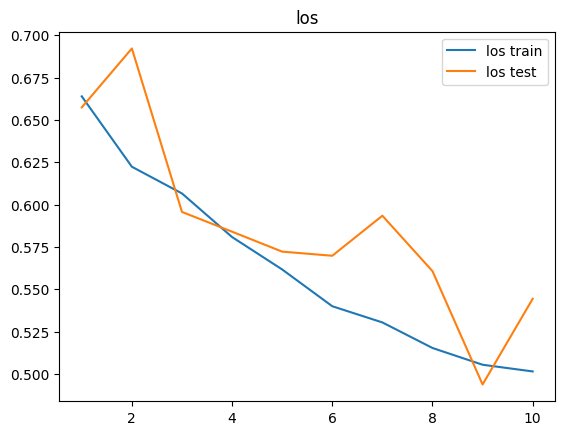

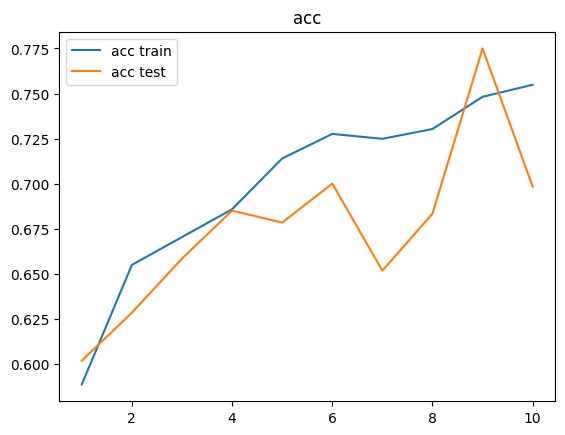

In [28]:
lr = 0.0007 # learning_rate
batch_size = 50 # we will use mini-batch method

model = Cnn().to(device)
model.train()

train_loader, test_loader, val_loader = create_loaders()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot([i.data for i in epoch_loss_list], epoch_val_loss_list, "los")
show_plot(epoch_accuracy_list, epoch_val_accuracy_list, "acc")

#### Работа с моделью

In [29]:
dog_probs = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(labels, preds_list))

dog_probs.sort(key = lambda x : int(x[0]))     
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

,id,label
0,800,0.298631
1,801,0.448845
2,802,0.201512
3,803,0.391763
4,804,0.191575
...,...,...
395,1895,0.575079
396,1896,0.857034
397,1897,0.783475
398,1898,0.639978


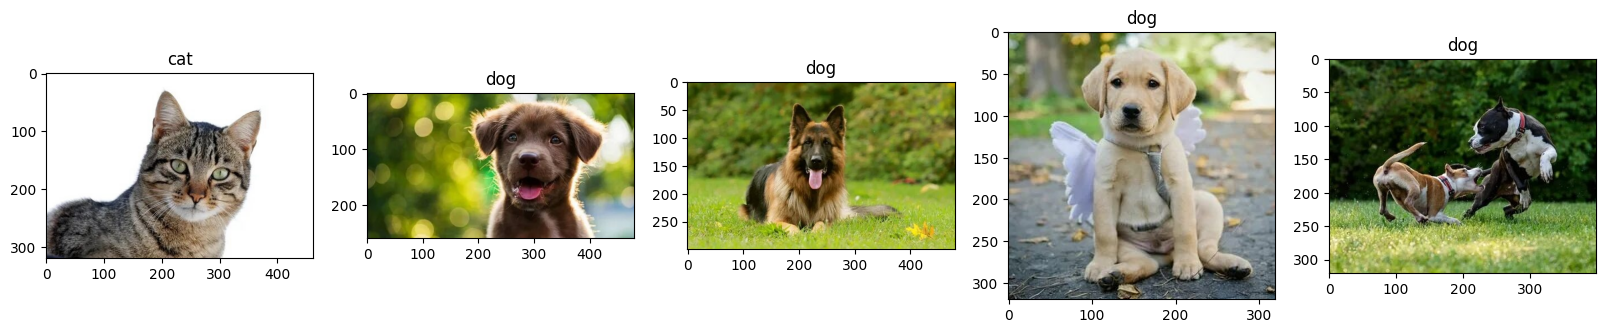

In [36]:
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)

#### Сохранение модели и работа на тестовых данных

In [39]:
torch.save(model.state_dict(), os.path.join("C:/Users/Professional/Desktop/labpython", "weight.pt"))

In [40]:
mymodel = Cnn()
mymodel.load_state_dict(torch.load(os.path.join("C:/Users/Professional/Desktop/labpython", "weight.pt")))

<All keys matched successfully>

'dog'

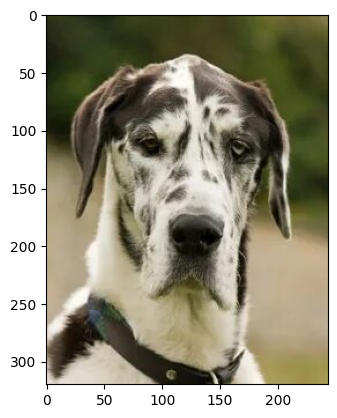

In [46]:


list_files = os.listdir(val_path)
file = list_files[random.randint(0,len(list_files)-1)]


img_path = os.path.join(val_path, file)

img = Image.open(img_path)
img_transformed = test_transforms(img).unsqueeze(dim=0)

output = mymodel(img_transformed)

img = Image.open(img_path)
plt.imshow(img)

preds_list = "cat" if output.argmax(dim=1) == 0 else "dog"

preds_list

In [50]:
l = []

train_loader, test_loader, val_loader = create_loaders()

for data, label in val_loader:
    output = mymodel(data)
    l.append(output.argmax(dim=1) == label)
l

[tensor([ True,  True,  True,  True,  True, False,  True,  True, False,  True,
          True,  True,  True, False,  True,  True,  True,  True, False, False,
          True,  True,  True,  True,  True, False,  True, False,  True,  True,
          True,  True,  True, False,  True,  True,  True, False,  True,  True,
         False,  True,  True, False,  True,  True,  True,  True,  True,  True]),
 tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
          True,  True,  True, False,  True, False,  True, False,  True, False,
          True,  True, False,  True,  True, False,  True,  True, False,  True,
          True,  True,  True,  True,  True,  True,  True, False,  True,  True,
          True,  True,  True,  True,  True, False,  True,  True,  True,  True]),
 tensor([False,  True,  True, False, False,  True,  True,  True, False, False,
          True, False,  True,  True,  True,  True, False,  True,  True,  True,
          True,  True,  True,  True,  True,  Tru

In [51]:
sum = 0
count = 0
for i in l:
    sum += torch.sum(i.float())
    count += len(i)

sum / count 

tensor(0.7389)